### Convergence analysis

In [7]:
import os
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pylab as plt

import nxcl
from nxcl.config import load_config, save_config, add_config_arguments, ConfigDict

from utils.parse import *
from utils.tree_util import *

from utils.metadata import get_nist, get_cifar
import pickle
from utils.metadata import *

import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
import gdown
id = "1T04CsJSS2ku-lx5I17TOsQVZuLQFpX_S"
output = './result/eval.zip'
gdown.download(id=id, output=output)
!unzip -q ./result/eval.zip

### Model Path

In [2]:
### c10
model1_path = './result/eval/c10_frn/2024_1_30_74550'
model2_path = './result/eval/c10_frn/2024_1_30_105910'
model3_path = './result/eval/c10_frn/2024_1_30_23418'

### ESS

In [29]:
# A6000
csg_epoch = 1.7938
meta_epoch = 2.4441
l2e_epoch = 2.645

In [31]:
lopt_ess_list = []

for model_path in [model1_path, model2_path , model3_path]:
    with open(f'{model_path}/model.pickle', 'rb') as f:
        param_list = pickle.load(f)
    flatten_param_list = [np.asarray(jax.flatten_util.ravel_pytree(params)[0]) for params in param_list]
    states = jnp.stack(flatten_param_list,0)
    lopt_ess = tfp.mcmc.effective_sample_size(states=states, filter_beyond_positive_pairs=False)
    # print(np.sum(lopt_ess))
    lopt_ess_list.append(np.sum(lopt_ess))

mean, std = np.asarray(lopt_ess_list).mean(), np.asarray(lopt_ess_list).std()
print(mean/l2e_epoch/100000, std/l2e_epoch/100000)

82.97792060491493 0.5161746810018903


### R hat

In [7]:
state_list = []

for model_path in [model1_path, model2_path , model3_path]:
    with open(f'{model_path}/model.pickle', 'rb') as f:
        param_list = pickle.load(f)
    flatten_param_list = [np.asarray(jax.flatten_util.ravel_pytree(params)[0]) for params in param_list]
    states = jnp.stack(flatten_param_list,0)
    state_list.append(states)

total_chain = jnp.stack(state_list,1)
# print(total_chain.shape)
Rhat_lopt = tfp.mcmc.diagnostic.potential_scale_reduction(total_chain, independent_chain_ndims=1)

len(Rhat_lopt[Rhat_lopt <1.2])/len(Rhat_lopt)

0.920021542025393

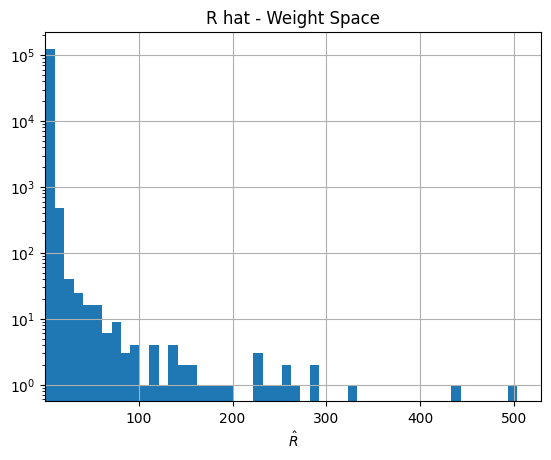

In [81]:
plt.hist(Rhat_lopt, log=True, bins=50)
plt.xlabel('$\^{R}$')
plt.title('R hat - Weight Space')
plt.grid(True)
plt.xlim(0.5, plt.xlim()[1])
plt.show()

### Rebuttal (Reviewer tZ3k) - Chain-wise rank normalized split- $c\hat{R_{\psi}^{(\kappa)}}$ (Sommer et al., 2024) and layer-wise $c\hat{R^{(\kappa)}}$

In [3]:
## utils.py in Sommer et al 2024 https://anonymous.4open.science/r/bnn_connecting_the_dots-E2DF/src/utils.py
import copy
import math
from typing import Callable

import jax
import jax.numpy as jnp


def rolling_average(x: jnp.array, window_size: int) -> jnp.array:
    """Calculate the rolling average of a JAX array."""
    return jnp.convolve(x.ravel(), jnp.ones(window_size), 'valid') / window_size


def mse(preds: jnp.array, y: jnp.array) -> tuple[float, float]:
    """Calculate the mean squared error and its standard deviation."""
    return (
        jnp.mean((preds.mean(axis=0).squeeze() - y.squeeze()) ** 2),
        jnp.std((preds.mean(axis=0).squeeze() - y.squeeze()) ** 2),
    )


def apply_statistic_to_dict(samples_dict: dict, statistic: Callable, **kwargs) -> dict:
    """
    Apply a statistic to each entry of a dictionary of samples.

    Args:
    samples_dict (dict): Dictionary of samples.
    statistic (function): Statistic to apply to each entry of the dictionary.
    **kwargs: Keyword arguments to pass to the statistic function.

    Returns:
    dict: Dictionary with the same keys as the input dictionary and the values are the
      statistic applied to the samples.
    """
    return {key: statistic(samples_dict[key], **kwargs) for key in samples_dict.keys()}


def add_chain_dimension(samples_dict: dict, n_chains: int):
    """
    Add a chain dimension to each entry of a dictionary of samples.

    Args:
    samples_dict (dict): Dictionary of samples.
    n_chains (int): Number of chains.

    Returns:
    dict: Dictionary with the same keys as the input dictionary and the values are the
      samples with an additional chain dimension.
    """
    # copy the samples_dict
    samples_d = copy.deepcopy(samples_dict)
    for key in samples_d.keys():
        samples_d[key] = jnp.reshape(
            samples_d[key], (n_chains, -1, *samples_d[key].shape[1:])
        )
    return samples_d


def flatten_chain_dimension(samples_dict: dict):
    """
    Flatten the chain dimension of each entry of a dictionary of samples.

    Args:
    samples_dict (dict): Dictionary of samples.

    Returns:
    dict: Dictionary with the same keys as the input dictionary and the values are the
      samples with the chain dimension flattened.
    """
    # copy the samples_dict
    samples_d = copy.deepcopy(samples_dict)
    for key in samples_d.keys():
        samples_d[key] = samples_d[key].reshape(-1, *samples_d[key].shape[2:])
    return samples_d


def rank_normalization(samples: jnp.array) -> jnp.array:
    """
    Rank normalization of a JAX array.

    Args:
    samples (ndarray): JAX array with the shape (n_samples, ...).

    Returns:
    ndarray: JAX array with the same shape as the input array.
    """
    n_samples = math.prod(samples.shape)
    ranks = jax.scipy.stats.rankdata(samples, axis=None).reshape(samples.shape)
    tmp = (ranks - 0.375) / (n_samples + 0.25)
    return jax.scipy.stats.norm.ppf(tmp)


def vectorized_rank_normalization(samples: jnp.array) -> jnp.array:
    """
    Vectorized rank normalization of a JAX array.

    Args:
    samples (ndarray): JAX array with the shape (n_chains, n_samples, ...).

    Returns:
    ndarray: JAX array with the same shape as the input array.
    """
    # reshape the first two dimensions to one
    n_chains = samples.shape[0]
    flattend_samples = samples.copy().reshape(-1, *samples.shape[2:])
    # apply the rank normalization for each ... dimension separately
    result = jnp.apply_along_axis(rank_normalization, 0, flattend_samples)
    # reshape the result to the original shape
    return jnp.reshape(result, (n_chains, -1, *result.shape[1:]))

In [4]:
## split_chain_r_hat function in Sommer et al 2024 https://anonymous.4open.science/r/bnn_connecting_the_dots-E2DF
def gelman_split_r_hat(
    samples: jax.Array,
    n_splits: int,
    rank_normalize: bool = True,
) -> jax.Array:
    """
    Calculate the split Gelman-Rubin R-hat statistic for samples of MCMC chains.

    Args:
    samples (ndarray): MCMC chains as a JAX array with the shape
    (n_chains, n_samples, ...).
    n_splits (int): Number of splits of the chains.

    Returns:
    rhat (ndarray): R-hat statistic for each parameter (the other dimensions) as a JAX
    array.
    """
    n_chains = samples.shape[0]
    if (n_chains == 1) & (n_splits == 1):
        raise ValueError('Only one chain, R_hat is not defined')

    # rank normalize the samples
    if rank_normalize:
        samples = vectorized_rank_normalization(samples)

    overall_splits = n_chains * n_splits
    n_samples = samples.shape[1] / n_splits
    if (n_samples % 1) != 0:
        raise ValueError('Number of samples must be divisible by n_splits')
    if n_samples < 50:
        print(
            'Warning! Nbr of samples should be at least 50 times the number of splits'
        )

    # flatten the chains first jnp.reshape(b, (-1, b.shape[-1]))
    chains = samples.copy().reshape(-1, *samples.shape[2:])
    # (n_eval_chains, n_samples, ...)
    chains = jnp.reshape(chains, (overall_splits, -1, *chains.shape[1:]))
    chain_means = jnp.mean(chains, axis=1)
    whithin_chain_var = jnp.mean(jnp.var(chains, axis=1, ddof=1), axis=0)
    between_chain_var = jnp.var(chain_means, axis=0, ddof=1)
    numerator = ((n_samples - 1) / n_samples) * whithin_chain_var + between_chain_var
    rhat = jnp.sqrt(numerator / whithin_chain_var)
    return rhat


def split_chain_r_hat(
    samples: jax.Array,
    n_splits: int,
    rank_normalize: bool = True,
) -> jax.Array:
    """
    Calculate the split chain R-hat statistic for samples of MCMC chains.

    Args:
    samples (ndarray): MCMC chains as a JAX array with the shape
    (n_chains, n_samples, ...).
    n_splits (int): Number of splits of the chains.
    rank_normalize (bool): Whether to rank normalize the samples before calculating

    Returns:
    dict: Dictionary with the following entries:
        split_chain_rhat (ndarray): split R-hat statistic for each chain and parameter
          (the other dimensions) as a JAX array.
        avg_split_chain_rhat (float): Mean of the split chain R-hat statistic over all
          parameters.
        rhat (ndarray): classic R-hat statistic for each parameter
        (the other dimensions) as a JAX array.
        split_normalized_rhat (ndarray): split R-hat normalized R-hat statistic.
    """
    n_chains = samples.shape[0]
    if n_chains == 1:
        raise ValueError('Only one chain, R_hat is not defined')

    # calc the splitrhat for each chain with a number of splits specified by n_splits
    # (n_chains, n_samples, ...)
    chains = samples.copy()
    split_chain_rhat = []
    for i in range(n_chains):
        split_chain_rhat.append(
            gelman_split_r_hat(
                chains[i, jnp.newaxis, ...],
                n_splits=n_splits,
                rank_normalize=rank_normalize,
            )
        )
    split_chain_rhat = jnp.array(split_chain_rhat)

    # then average the splitrhat over the chains for each parameter
    avg_split_chain_rhat = jnp.mean(split_chain_rhat, axis=0)

    # now calculate the rhat for each parameter
    rhat = gelman_split_r_hat(samples.copy(), n_splits=1, rank_normalize=True)

    # divide the rhat by the avg_split_chain_rhat
    split_normalized_rhat = (avg_split_chain_rhat + rhat - 1) / (avg_split_chain_rhat)

    return {
        'split_chain_rhat': split_chain_rhat,
        'avg_split_chain_rhat': avg_split_chain_rhat,
        'rhat': rhat,
        'split_normalized_rhat': split_normalized_rhat,
    }


In [8]:
state_list = []

for model_path in [model1_path, model2_path , model3_path]:
    with open(f'{model_path}/model.pickle', 'rb') as f:
        param_list = pickle.load(f)
    flatten_param_list = [np.asarray(jax.flatten_util.ravel_pytree(params)[0]) for params in param_list]
    states = jnp.stack(flatten_param_list, 0)
    state_list.append(states)

total_chain = jnp.stack(state_list,1)
print(total_chain.shape)
Rhat_lopt = tfp.mcmc.diagnostic.potential_scale_reduction(total_chain, independent_chain_ndims=1, split_chains=True) # Vehtari

total_chain = jnp.swapaxes(total_chain,0,1) # (n_chains,n_samples,n_dim)
print(total_chain.shape)
results = split_chain_r_hat(total_chain, n_splits=2, rank_normalize=True)

(100, 3, 271098)
(3, 100, 271098)


In [9]:
### Chain-wise Rhat for CIFAR-10
for idx,rhat_new in enumerate(results['split_chain_rhat']):
    print(f'cRhat of chain {idx} : {len(rhat_new[rhat_new <1.1])/len(rhat_new)}')

cRhat of chain 0 : 0.9683472397435614
cRhat of chain 1 : 0.9684800330507787
cRhat of chain 2 : 0.9669787309386274


#### Visualization of Layer-wise $c\hat{R_{\psi}^{(\kappa)}}$

In [10]:
state_list = []
param_lists = []
for model_path in [model1_path, model2_path, model3_path]:
    with open(f'{model_path}/model.pickle', 'rb') as f:
        param_list = pickle.load(f)
    base_params = param_list[0]
    base_params = jax.tree_util.tree_map(lambda x: jnp.expand_dims(x,0), base_params)
    for idx,params in enumerate(param_list[1:]):
        params = jax.tree_util.tree_map(lambda x: jnp.expand_dims(x,0), params)
        base_params = jax.tree_util.tree_map(lambda x,y: jnp.concatenate((x,y), 0), base_params,params)

    param_lists.append(base_params)

base_params = jax.tree_util.tree_map(lambda x,y,z: jnp.stack((x,y,z), 0), *param_lists) # pytree of [num_chain, num_particles, *param_dim] array

In [ ]:
flatten_base_params = jax.tree_util.tree_map(lambda x: x.reshape(x.shape[0], x.shape[1],-1), base_params) # flatten param_dim (conv layer)
print(jax.tree_util.tree_map(lambda x: x.shape, flatten_base_params))

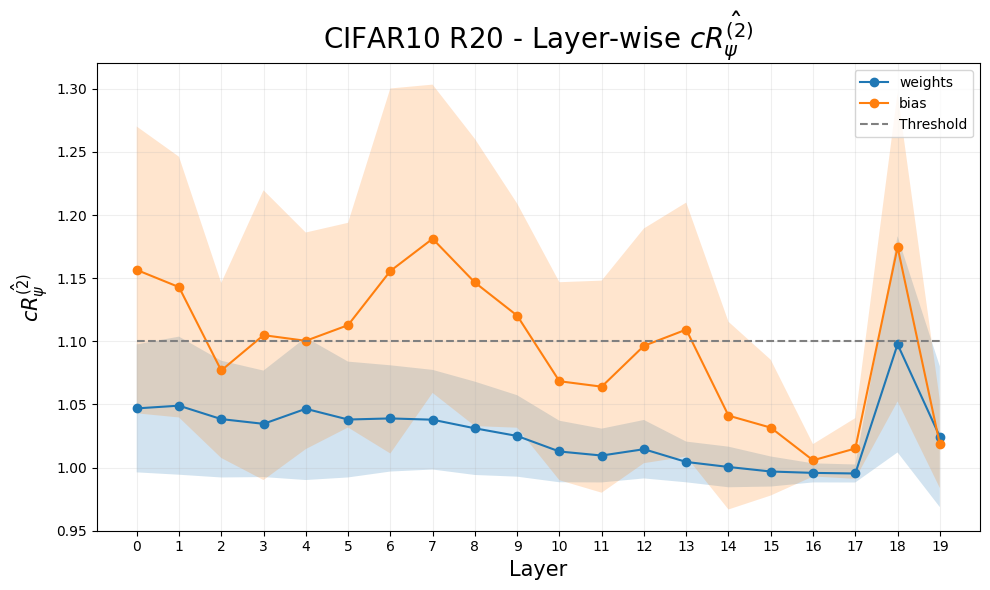

In [18]:
weights_layer_list = []
bias_layer_list = []

weights_results_list = []
bias_results_list = []

weights_results_std = []
bias_results_std = []


for key in flatten_base_params.keys():
    try:
        weights_layer_list.append(flatten_base_params[key]['w'])
    except:
        pass
for key in flatten_base_params.keys():
    try:
        bias_layer_list.append(flatten_base_params[key]['b'])
    except:
        pass

fig,axes = plt.subplots(figsize=(10, 6))

for layer_bias,layer_weights in zip(bias_layer_list, weights_layer_list):
    results_weights = split_chain_r_hat(layer_weights, n_splits=2, rank_normalize=True)
    results_bias = split_chain_r_hat(layer_bias, n_splits=2, rank_normalize=True)

    weights_results_list.append(results_weights['avg_split_chain_rhat'].mean())
    bias_results_list.append(results_bias['avg_split_chain_rhat'].mean())
    weights_results_std.append(results_weights['avg_split_chain_rhat'].std())
    bias_results_std.append(results_bias['avg_split_chain_rhat'].std())


plt.plot(range(len(weights_results_list)), weights_results_list, marker='o', label='weights')
plt.fill_between(range(len(weights_results_list)), np.array(weights_results_list)-np.array(weights_results_std), \
    np.array(weights_results_list)+np.array(weights_results_std), alpha=0.2)

plt.plot(range(len(bias_results_list)), bias_results_list, marker='o', label='bias')
plt.fill_between(range(len(bias_results_list)), np.array(bias_results_list)-np.array(bias_results_std), \
    np.array(bias_results_list)+np.array(bias_results_std), alpha=0.2)

plt.plot(range(len(bias_results_list)),[1.1]*20, linestyle='dashed', label='Threshold', color='0.5')


plt.legend()

plt.grid(True, alpha=0.2)
plt.title("CIFAR10 R20 - Layer-wise " r"$c\hat{R_{\psi}^{(2)}}$", fontsize=20)
plt.xlabel('Layer', fontsize=15)
plt.ylabel(r"$c\hat{R_{\psi}^{(2)}}$", fontsize=15)
plt.xticks(range(len(bias_results_list)))
plt.tight_layout()
plt.savefig('./plot/layerwise_r_hat.pdf')